In [1]:
import warnings
warnings.filterwarnings('ignore')
import json

from qiskit.tools.jupyter import *
from qiskit import IBMQ
from qiskit import pulse                  # This is where we access all of our Pulse features!
from qiskit.circuit import Parameter      # This is Parameter Class for variable parameters.
from qiskit.circuit import QuantumCircuit, Gate
from qiskit import transpile, schedule, assemble
from qiskit.tools.monitor import job_monitor

import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

from scipy.optimize import curve_fit

In [3]:
import sys, os
sys.path.insert(0, '../../..')
from utils.circuit_utils import get_closest_multiple_of, get_closest_multiple_of_16
from utils.job_utils import get_job_data, save_job, load_job
from utils.result_utils import baseline_remove, fit_function, single_qubit_count
from utils.higher_energy_states.pulse_gate import Sched
from utils.higher_energy_states.state_prep import gen_circ

In [ ]:
with open(r"../../provider.json", "r") as f:
    credential = json.load(f)

IBMQ.load_account()
provider = IBMQ.get_provider(hub = credential["hub"], group = credential["group"], project = credential["project"])
backend = provider.get_backend("ibm_lagos")

In [5]:
sched = Sched(backend)
sched.load_gate_data(os.path.join("..", "..", "data", f"{backend.configuration().backend_name}_gate_data.json"))
sched.create_scheds()

In [ ]:
num_qubits = backend.configuration().n_qubits
acquire_alignment = backend.configuration().timing_constraints['acquire_alignment']
granularity = backend.configuration().timing_constraints['granularity']
pulse_alignment = backend.configuration().timing_constraints['pulse_alignment']
dt = backend.configuration().dt
basis_gates = backend.configuration().basis_gates
basis_gates

In [6]:
colors = ['grey', 'green', 'crimson', 'cornflowerblue']

# VQE

## State Prepare Circuit

In [7]:
sched_list = [0, 1, 2]
state_prep_circ_list = [
    [gen_circ(state, num_qubits, qubit_list = sched_list, sched = sched, sched_list = sched_list, num_reset = 0, reset_list = None, measure = False) for state in range(4)],
    [gen_circ(state, num_qubits, qubit_list = sched_list, sched = sched, sched_list = sched_list, num_reset = 1, reset_list = None, measure = False) for state in range(4)],
    [gen_circ(state, num_qubits, qubit_list = sched_list, sched = sched, sched_list = sched_list, num_reset = 1, reset_list = None, add_secure_reset=True, measure = False) for state in range(4)],
    ]

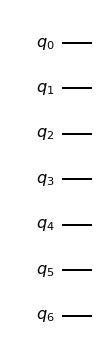

In [8]:
state_prep_circ_list[0][0].draw()

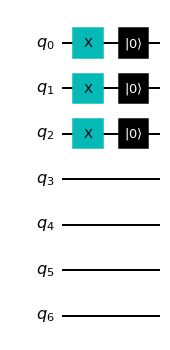

In [9]:
state_prep_circ_list[1][1].draw()

## Ansatz

In [10]:
ansatz_qubit_list = [0, 1, 2]

from qiskit.circuit.library import EfficientSU2

ansatz_op = EfficientSU2(3, reps=1, entanglement="linear", insert_barriers=True)
ansatz = QuantumCircuit(num_qubits)
ansatz.compose(ansatz_op, qubits = ansatz_qubit_list, inplace=True)
ansatz = ansatz.decompose()
H = [(1, "IIIIIZZ")]
np.random.seed(0)  # seed for reproducibility
initial_point = np.random.random(ansatz.num_parameters)

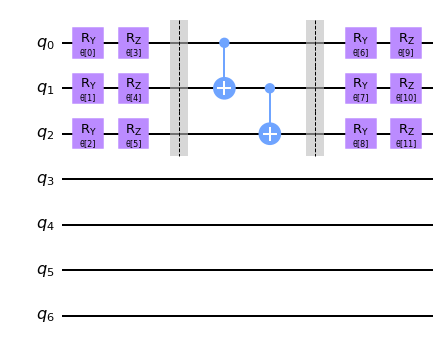

In [11]:
ansatz.draw()

## Submit

In [12]:
from qiskit_ibm_runtime import QiskitRuntimeService

service = QiskitRuntimeService(channel="ibm_quantum")

In [13]:
inputs = {}
inputs["hamiltonian"] = H
inputs["ansatz_circ"] = ansatz
inputs["initial_parameters"] = initial_point
inputs["num_reset_after_prep"] = 0
inputs["optimizer_config"] = {"maxiter": 100}
inputs["use_measurement_mitigation"] = True
inputs["shots"] = 1024

In [14]:
# inputs["state_prep_circ"] = state_prep_circ_list[1][3]
inputs["rep_delay"] = 250e-6
# inputs["rep_delay"] = None
inputs["init_qubits"] = False
inputs["add_delay_after_meas"] = True

In [17]:
# job_id_list = [
#   ['cd615kl7c0nkk2r74sa0',
#  'cd66fv57c0nkk2r7bapg',
#  'cd615kvq8825uamjpka0',
#  'cd615kt7c0nkk2r74sbg'],

#   ['cd6bmppep4kks1rp5nmg',
#  'cd692q1ep4kks1rp3170',
#  'cd61414hragmaklr3trg',
#  'cd61419ep4kks1roq560'],

#   ['cd3a65r4ieg2adusk5kg',
#  'cd3a6664kdfe4vbj7fb0',
#  'cd614cpep4kks1roq5jg',
#  'cd614d3fuj2huvlgmvbg'],

#  ['cd9umok0k06fm5ih0bkg',
#  'cd8k5kniov02gvt3th90',
#  'cda84j0rj70e332th2l0', 
#  'cdate3ndnm3ej1lkd0mg'],

#  ['cd8k5sniov02gvt3tio0',
#  'cda19r40k06fm5ih89t0',
#  'cd8k5sssnna38a9cpdlg',
#  'cd8k5t530nhm9tudgqeg'],

#  ['cd9uo0fdnm3ej1lhhubg',
#  'cd8k66csnna38a9cpfd0',
#  'cdateefdnm3ej1lkd1o0', 
#  'cdateef42nsrp9o3b8n0'],

#  ['cdkqmpmh8o8scsh85fd0', 
#  'cdkqmpntlcfkm5f06i4g',
#  'ce59vgdql57g9ai4cn0g', 
#  'ce59vgmcnq5vfe59npi0']
# ]

# job_list = [[service.job(job_id) for job_id in job_ids_state] for job_ids_state in job_id_list]

In [19]:
mechanism_list = ["Default", "Reset_0", "CSR_0", "CSR_250", "Reset_125", "CSR_125", "Reset_250"]

In [14]:
# import json, os
# from qiskit.providers.jobstatus import JOB_FINAL_STATES

# mechanism_list = ["Default", "Reset_0", "CSR_0", "CSR_250", "Reset_125", "CSR_125", "Reset_250"]
# assert (len(job_list) == len(mechanism_list))
# for mechanism_idx, mechanism in enumerate(mechanism_list):
#     for state in range(len(job_list[0])):
#         if state < len(job_list[mechanism_idx]):
#             job = job_list[mechanism_idx][state]
#             if job.status() in JOB_FINAL_STATES:
#                 interim_result = job.interim_results()
#                 if interim_result:
#                     with open(os.path.join("result", f"interim_results_{mechanism_idx}_{state}.json"), "w") as f:
#                         json.dump(interim_result, f, indent = 4)

In [20]:
import json

interim_result_list = []
for mechanism_idx in range(7):
    interim_result_mechanism_list = []
    for state in range(4):
        filename = os.path.join("result", f"interim_results_{mechanism_idx}_{state}.json")
        if os.path.exists(filename):
            with open(filename, "r") as f:
                interim_result = [json.loads(interim_str) for interim_str in list(reversed(json.load(f)))]
                interim_result_mechanism_list.append(interim_result)
    interim_result_list.append(interim_result_mechanism_list)


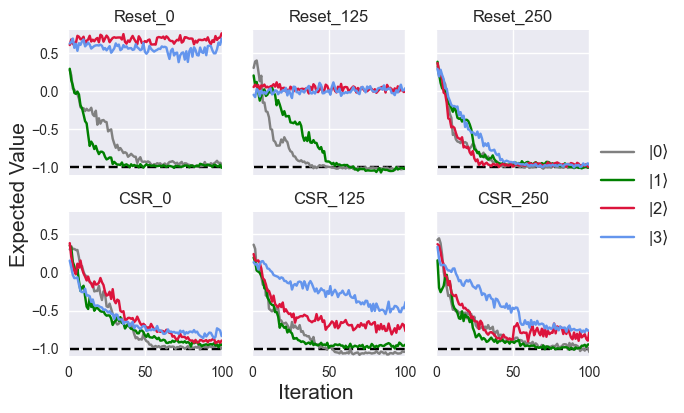

In [23]:
import json
from operator import ne

target_energy = -1

mpl.style.use('seaborn')

fig, axes = plt.subplots(2, 3, figsize = (6, 4), dpi = 100, sharey=True, sharex=True)
for plot_idx, mechanism_idx in enumerate([1, 4, 0, 2, 5, 3]):
    mechanism = mechanism_list[mechanism_idx]
    x_max = min(100, len(min(interim_result_list[mechanism_idx], key=len)))
    axes[int(plot_idx/3)][plot_idx%3].plot([1, x_max], [target_energy, target_energy], linestyle = "--", label = "Target", c = "black")
    for state, interim_result_state in enumerate(interim_result_list[mechanism_idx]):
        axes[int(plot_idx/3)][plot_idx%3].plot(np.arange(x_max) + 1, [interim_result[-1] for interim_result in interim_result_state[:x_max]], label = f"|{state}"r"$\rangle$", c = colors[state])
    # axes[int(plot_idx/3)][plot_idx%3].set_xlabel("Iteration")
    # axes[int(plot_idx/3)][plot_idx%3].set_ylabel("Energy")
    axes[int(plot_idx/3)][plot_idx%3].set_xlim([0, x_max])
    axes[int(plot_idx/3)][plot_idx%3].set_ylim([-1.1, 0.8])
    axes[int(plot_idx/3)][plot_idx%3].set_title(mechanism)

    # if mechanism_idx == len(interim_result_list)-1:
    #     axes[int(mechanism_idx/3)][mechanism_idx%3].legend(loc='center left', bbox_to_anchor=(1, 0.5))

fig.text(0.5, -0.01, "Iteration", fontsize=15, ha='center')
fig.text(-0.01, 0.5, "Expected Value", fontsize=15, va='center', rotation='vertical')
# fig.supxlabel("Iteration", fontsize=15)
# fig.supylabel("Expected Value", fontsize=15)

from matplotlib.lines import Line2D
handles=[]
for state in range(4):
    handles.append(Line2D([0], [0], label=f"|{state}"r"$\rangle$", color=colors[state]))
fig.legend(handles = handles, fontsize=12, loc='center left', bbox_to_anchor=(0.95, 0.5))

# plt.subplots_adjust(left=0.15, right=0.85, bottom=0.15, top=1.0)
plt.tight_layout()

# plt.savefig("./figs/vqe.pdf", bbox_inches="tight")